# Imports

In [ ]:
!pip install git+https://github.com/seidlr/LaurieOnTracking.git

In [1]:
#importing necessary libraries
import friendsoftracking.metrica.IO as mio
import friendsoftracking.metrica.Viz as mviz
import friendsoftracking.metrica.Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
import statsmodels.formula.api as smf
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Read data 

## Read player x,y coordinates

In [2]:
#Change data directory #add to description where you can put the Metrica data
path = 'final_home.csv'
game_id = 2312135

def to_single_playing_direction(home):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home]:
        print(team.Period)
        second_half_idx = len(team[team['Period'] == 1]["Time [s]"].tolist()) + 1
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home


tracking_home = pd.read_csv(path)

tracking_home = tracking_home.loc[:, ~tracking_home.isnull().all()]
tracking_home = to_single_playing_direction(tracking_home)


tracking_home.head()


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
164995    2.0
164996    2.0
164997    2.0
164998    2.0
164999    2.0
Name: Period, Length: 165000, dtype: float64


,Unnamed: 0,Period,Time [s],Home_87dbfea7-b4c1-49ce-b210-6210f5efae55_x,Home_87dbfea7-b4c1-49ce-b210-6210f5efae55_y,Home_08d71d20-85ad-4d98-8bc0-36b8e39e517a_x,Home_08d71d20-85ad-4d98-8bc0-36b8e39e517a_y,Home_8c34093f-843c-41a4-b02d-1ed289de00a3_x,Home_8c34093f-843c-41a4-b02d-1ed289de00a3_y,Home_3706abe8-9aba-49c6-8a8f-4f4ef2a9be70_x,...,Home_0746befc-a701-4b33-8faf-b3cccccf17bb_x,Home_0746befc-a701-4b33-8faf-b3cccccf17bb_y,Home_db47bb9a-634f-4ef6-9cd0-d6daf74164d7_x,Home_db47bb9a-634f-4ef6-9cd0-d6daf74164d7_y,Home_aa53177e-f36d-4298-9c67-3c93a49c3325_x,Home_aa53177e-f36d-4298-9c67-3c93a49c3325_y,Home_471aedfa-df6f-44b4-b008-7b2cef31f3cb_x,Home_471aedfa-df6f-44b4-b008-7b2cef31f3cb_y,Home_1ab5dc11-1e32-4e6b-a385-5b736ec14763_x,Home_1ab5dc11-1e32-4e6b-a385-5b736ec14763_y
0,0,1.0,0.00,NaN,NaN,-0.15,-30.50,-12.99,-23.00,-46.26,...,-11.08,1.55,-0.12,24.02,-21.61,-8.56,-1.20,-13.96,-2.71,8.54
1,1,1.0,0.04,NaN,NaN,-0.16,-30.45,-13.00,-23.03,-46.22,...,-11.08,1.57,-0.12,24.01,-21.60,-8.56,-1.22,-13.95,-2.71,8.52
2,2,1.0,0.08,NaN,NaN,-0.18,-30.41,-13.00,-23.05,-46.18,...,-11.07,1.59,-0.12,24.01,-21.58,-8.56,-1.24,-13.93,-2.71,8.50
3,3,1.0,0.12,NaN,NaN,-0.20,-30.37,-13.01,-23.07,-46.14,...,-11.07,1.61,-0.12,24.00,-21.57,-8.56,-1.27,-13.92,-2.72,8.48
4,4,1.0,0.16,NaN,NaN,-0.22,-30.34,-13.01,-23.09,-46.10,...,-11.05,1.63,-0.11,24.00,-21.56,-8.56,-1.29,-13.90,-2.72,8.46


In [ ]:
tracking_home

## Read player info (mapping player ID to name)

In [3]:
player_info = pd.read_csv("../final_data/player.csv") # map id to name
player_meta = pd.read_csv("../final_data/players_match_meta.csv") # map id to position

### function to calculate player velocities. Obtained from Metrica Python Library

In [4]:
import scipy.signal as signal

def remove_player_velocities(team):
    # remove player velocoties and acceleeration measures that are already in the 'team' dataframe
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']] # Get the player ids
    team = team.drop(columns=columns)
    return team

def calc_player_velocities(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )
    
    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    # remove any velocity data already in the dataframe
    team = remove_player_velocities(team)
    
    # Get the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home'] ] )

    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()
    
    # index of first frame in second half
    second_half_idx = len(team[team['Period'] == 1]["Time [s]"].tolist()) + 1
    
    # estimate velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan
            
        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window 
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' ) 
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )      
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' ) 
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' ) 
                
        
        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team


## Show players in game, their name and position

In [5]:
players_in_match = []
players_name_and_pos = {}
players_name_and_pos_conc = {}
for i in tracking_home.columns[3:].tolist():
    p_val = i.split("_")[1]
    if(p_val not in players_in_match):
        players_in_match.append(p_val)
    else:
        continue


for i in players_in_match:
    players_name_and_pos[i] = [player_info[player_info["ssiId"] == i]["name"].tolist()[0],
                               player_meta[player_meta["ssiId"] == i]["position"].tolist()[0]]
    
    


for i in players_name_and_pos:
    players_name_and_pos_conc[i] = players_name_and_pos[i][0] + " - " +players_name_and_pos[i][1]

players_name_and_pos_conc

{'87dbfea7-b4c1-49ce-b210-6210f5efae55': 'H. Raso - SUB',
 '08d71d20-85ad-4d98-8bc0-36b8e39e517a': 'C. Kelly - FW',
 '8c34093f-843c-41a4-b02d-1ed289de00a3': 'K. Casparij - DF',
 '3706abe8-9aba-49c6-8a8f-4f4ef2a9be70': 'E. Roebuck - GK',
 'a5ec6d76-4788-4894-bea2-0a165d4a36ba': 'A. Greenwood - DF',
 'eb23d9b0-cf56-4eb2-9a72-0022f70e3125': 'L. Aleixandri - DF',
 '724f3280-015e-440e-b9b7-0598833e9c2d': 'Khadija Shaw - FW',
 '0746befc-a701-4b33-8faf-b3cccccf17bb': 'Y. Hasegawa - MF',
 'db47bb9a-634f-4ef6-9cd0-d6daf74164d7': 'L. Hemp - FW',
 'aa53177e-f36d-4298-9c67-3c93a49c3325': 'S. Houghton - DF',
 '471aedfa-df6f-44b4-b008-7b2cef31f3cb': 'Filippa Angeldahl - MF',
 '1ab5dc11-1e32-4e6b-a385-5b736ec14763': 'L. Coombs - MF'}

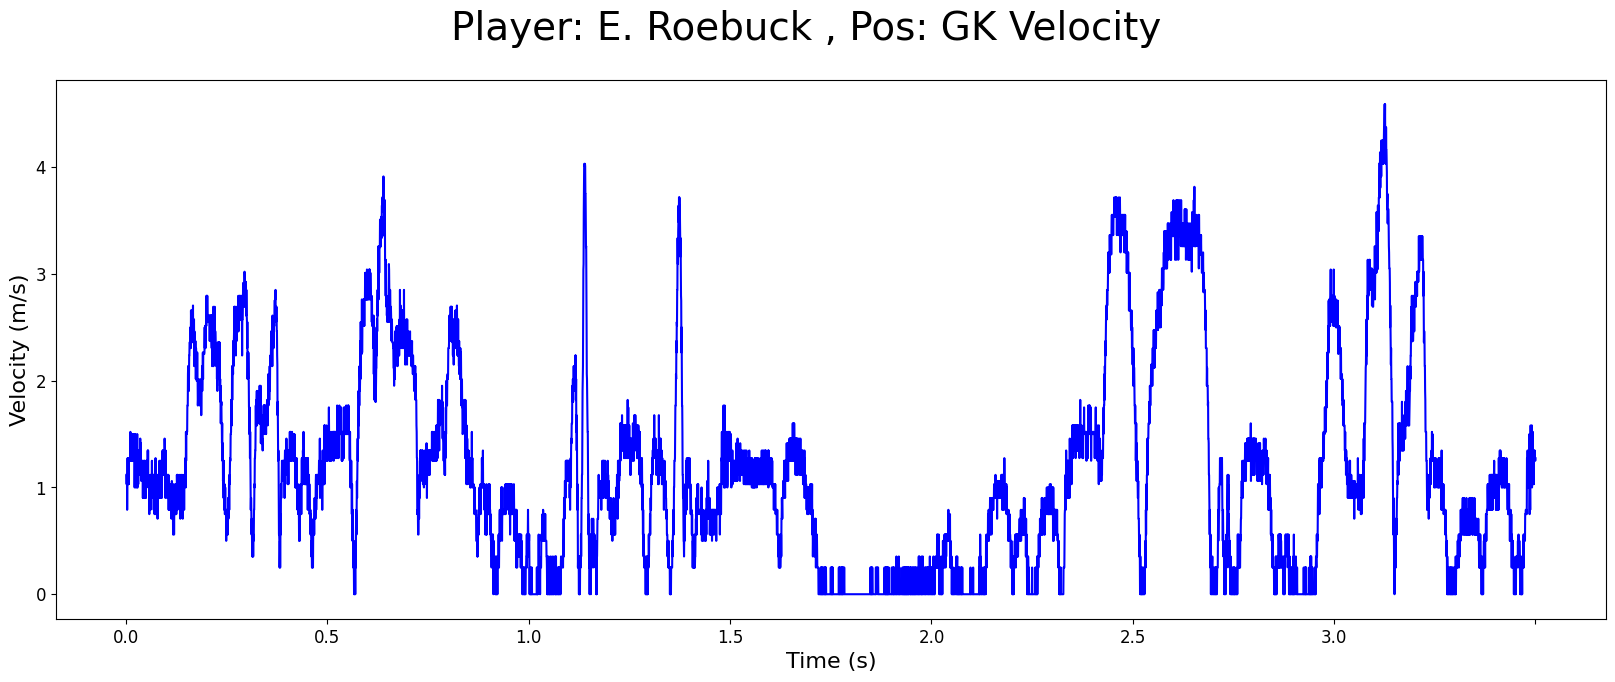

In [6]:
player_to_calc_speed = "3706abe8-9aba-49c6-8a8f-4f4ef2a9be70"

# Calculate the Player Velocities
player_ids = np.unique(list(c[:-2] for c in tracking_home.columns if c[:4] in ['Home']))
#impossible to run faster than 12 m/s
maxspeed = 12
dt = tracking_home['Time [s]'].diff()
#get first frame of second half
second_half_idx = len(tracking_home[tracking_home['Period'] == 1]["Time [s]"].tolist()) + 1

tracking_home_unsmoothed = calc_player_velocities(tracking_home, smoothing=False)

fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(range(1, 7001), tracking_home_unsmoothed.loc[1:7000]['Home_'+player_to_calc_speed+'_speed'], color = "blue")
ax.set_ylabel('Velocity (m/s)', fontsize = 16)
ax.set_xlabel('Time (s)', fontsize = 16)
ax.set_xticklabels([(i-1)*0.5 for i in range(8)])
unsmoothed_vel = tracking_home_unsmoothed.loc[1:21000]['Home_'+player_to_calc_speed+'_speed']
ax.tick_params(axis='both', which='major', labelsize=12)
# Using Laurie's smoothing code

tracking_home = calc_player_velocities(tracking_home, smoothing=True)



fig.suptitle(f"Player: {players_name_and_pos[player_to_calc_speed][0]} , Pos: {players_name_and_pos[player_to_calc_speed][1]} Velocity", fontsize = 28)
plt.show()

## Distance Covered By each player

In [7]:
# get home players
home_players = players_name_and_pos_conc.keys()
home_summary = pd.DataFrame(index=home_players) 

#calculating minutes played
minutes_home = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = (tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1) / 25 / 60. # convert to minutes
    minutes_home.append( player_minutes )
home_summary['Minutes Played'] = minutes_home
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

#calculating distance covered
distance_home = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[
                          column].sum() / 25. / 1000  # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance_home.append(player_distance)
home_summary['Distance [km]'] = distance_home
home_summary['Name_Pos'] = home_summary.index
home_summary = home_summary.replace({"Name_Pos": players_name_and_pos_conc})
home_summary

,Minutes Played,Distance [km],Name_Pos
8c34093f-843c-41a4-b02d-1ed289de00a3,97.112667,9.876974,K. Casparij - DF
3706abe8-9aba-49c6-8a8f-4f4ef2a9be70,97.112667,4.479006,E. Roebuck - GK
a5ec6d76-4788-4894-bea2-0a165d4a36ba,97.112667,9.237762,A. Greenwood - DF
eb23d9b0-cf56-4eb2-9a72-0022f70e3125,97.112667,9.859309,L. Aleixandri - DF
724f3280-015e-440e-b9b7-0598833e9c2d,97.112667,10.153965,Khadija Shaw - FW
0746befc-a701-4b33-8faf-b3cccccf17bb,97.112667,10.603706,Y. Hasegawa - MF
db47bb9a-634f-4ef6-9cd0-d6daf74164d7,97.112667,9.492129,L. Hemp - FW
aa53177e-f36d-4298-9c67-3c93a49c3325,97.112667,9.442748,S. Houghton - DF
471aedfa-df6f-44b4-b008-7b2cef31f3cb,97.112667,11.251351,Filippa Angeldahl - MF
1ab5dc11-1e32-4e6b-a385-5b736ec14763,97.112667,10.540088,L. Coombs - MF


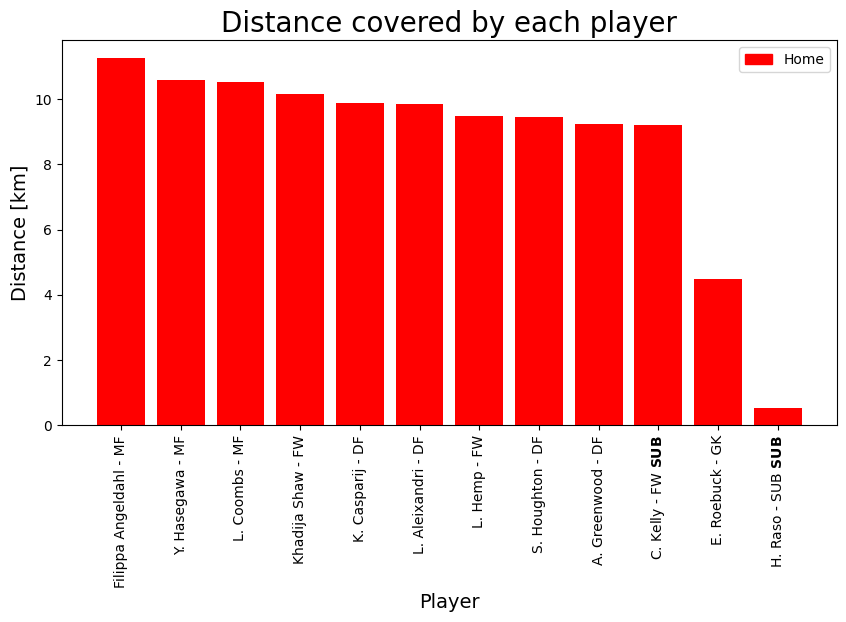

In [8]:
home_summary['Team'] = 'Home'

#create summary dataframe to make a plot
game_summary = pd.concat([home_summary])
game_summary['isSub'] = np.where(game_summary['Minutes Played']== max(game_summary['Minutes Played']),0,1)
game_summary_sorted = game_summary.sort_values(['Team', 'Distance [km]'], ascending=[False, False])
game_summary_sorted['Player'] = game_summary_sorted.index
#star mean that player was subbed in or of
game_summary_sorted["Name_Pos"] = game_summary_sorted["Player"]
game_summary_sorted = game_summary_sorted.replace({"Name_Pos": players_name_and_pos_conc})
game_summary_sorted['Name_Pos'] = np.where(game_summary_sorted['isSub']==0, game_summary_sorted['Name_Pos'], game_summary_sorted['Name_Pos']+ r" $\bf{SUB}$")

#make plot
colors = ['red' for _ in range(len(home_summary))]
color_map = {'Home':'red'}
labels = list(color_map.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]

plt.figure(figsize=(10,5))
plt.bar(game_summary_sorted['Name_Pos'], game_summary_sorted['Distance [km]'], color=colors)
plt.xlabel("Player", fontsize = 14)
plt.xticks(rotation=90)
plt.ylabel("Distance [km]", fontsize = 14)
plt.title("Distance covered by each player", fontsize = 20)
plt.legend(handles, labels)
plt.show()

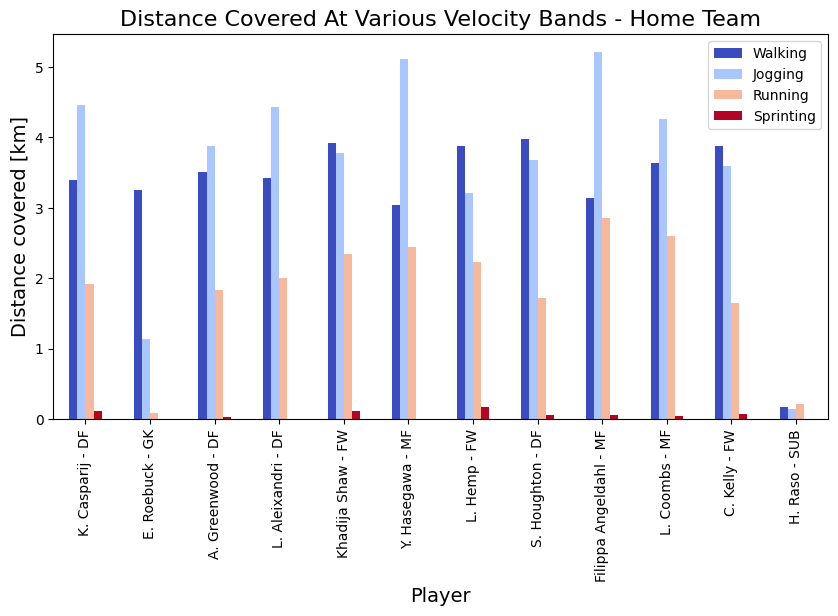

In [9]:
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum() / 25. / 1000
    walking.append(player_distance)
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[
                          (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum() / 25. / 1000
    jogging.append(player_distance)
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[
                          (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum() / 25. / 1000
    running.append(player_distance)
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[tracking_home[column] >= 7, column].sum() / 25. / 1000
    sprinting.append(player_distance)

home_summary['Walking'] = walking
home_summary['Jogging'] = jogging
home_summary['Running'] = running
home_summary['Sprinting'] = sprinting
home_summary['Name_Pos'] = home_summary.index
home_summary = home_summary.replace({"Name_Pos": players_name_and_pos_conc})

ax = home_summary.set_index('Name_Pos')[['Walking','Jogging','Running','Sprinting']].plot.bar( colormap='coolwarm', figsize=(10, 5))
ax.set_xlabel('Player', fontsize = 14)
ax.set_ylabel('Distance covered [km]', fontsize = 14)
ax.set_title('Distance Covered At Various Velocity Bands - Home Team', fontsize = 16)
plt.show()

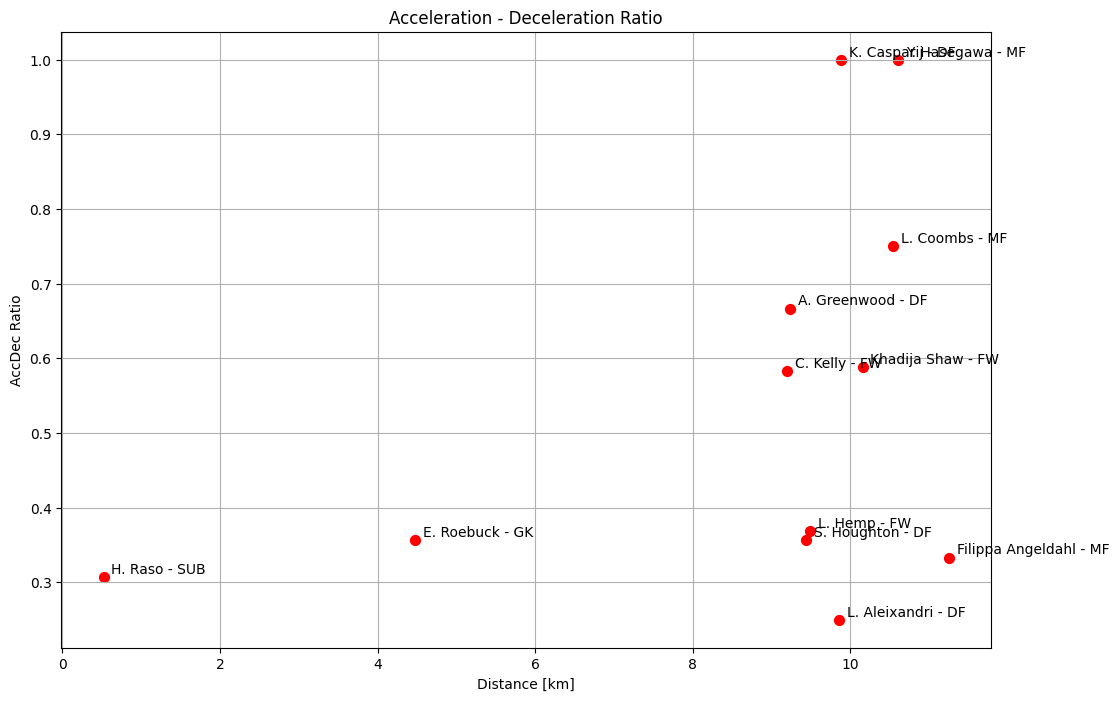

In [10]:
maxacc = 6
home_acc_dict = {}

for player in home_players:
    #calculate acceleration

    tracking_home['Home_' + player + '_Acc'] = tracking_home['Home_' + player + '_speed'].diff() / dt
    #set acceleration condition
    tracking_home['Home_' + player + '_Acc'].loc[np.absolute(tracking_home['Home_' + player + '_Acc']) > maxacc] = np.nan
    ##check if acceleration was high or low
    tracking_home['Home_' + player + '_Acc_type'] = np.where(np.absolute(tracking_home['Home_' + player + '_Acc']) >= 2,
                                                             "High", "Low")
    tracking_home['Home_' + player + '_Acc_g'] = tracking_home['Home_' + player + '_Acc_type'].ne(
        tracking_home['Home_' + player + '_Acc_type'].shift()).cumsum()

    #for each player
    for g in np.unique(tracking_home['Home_' + player + '_Acc_g']):
        acc_temp = tracking_home[tracking_home['Home_' + player + '_Acc_g'] == g]
        if acc_temp['Home_' + player + '_Acc_type'].iloc[0] == 'High':
            #get the acceleration period
            acc_duration = round(max(acc_temp['Time [s]']) - min(acc_temp['Time [s]']), 2)
            #check if it was acceleration or deceleration
            acc_or_dec = np.where(np.mean(acc_temp['Home_'+player+'_Acc']) > 0, "Acc", "Dec")
            #create a dictionary
            home_acc_dict[len(home_acc_dict) + 1] = {'Player': player, 'Group': g, 'Duration': acc_duration,
                                                     'Type': acc_or_dec}

home_acc_df = pd.DataFrame.from_dict(home_acc_dict,orient='index')
#get accelerations that were longer than 0.75 sec
home_acc_df1 = home_acc_df[home_acc_df['Duration']>=.75]


#calculate ratio for each player fo the home team
accdec = []
for player in home_players:
    accs = home_acc_df1[(home_acc_df1['Player']==player) & (home_acc_df1['Type']=='Acc')].count()[0]
    decs = home_acc_df1[(home_acc_df1['Player']==player) & (home_acc_df1['Type']=='Dec')].count()[0]
    ac_ratio = accs / decs
    accdec.append(ac_ratio)
#saving it in a dataframe
home_summary['AccDec'] = accdec

#making a plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(home_summary['Distance [km]'], home_summary['AccDec'], color = "red", s = 50)
for i in home_summary.index:
    ax.annotate(str(home_summary[home_summary.index==i]['Name_Pos'].tolist()[0]), 
                (home_summary[home_summary.index==i]['Distance [km]']+ 0.1, 
                 home_summary[home_summary.index==i]['AccDec'] + 0.005), fontsize = 10)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("AccDec Ratio")
plt.grid()
plt.title("Acceleration - Deceleration Ratio")
plt.show()

165000


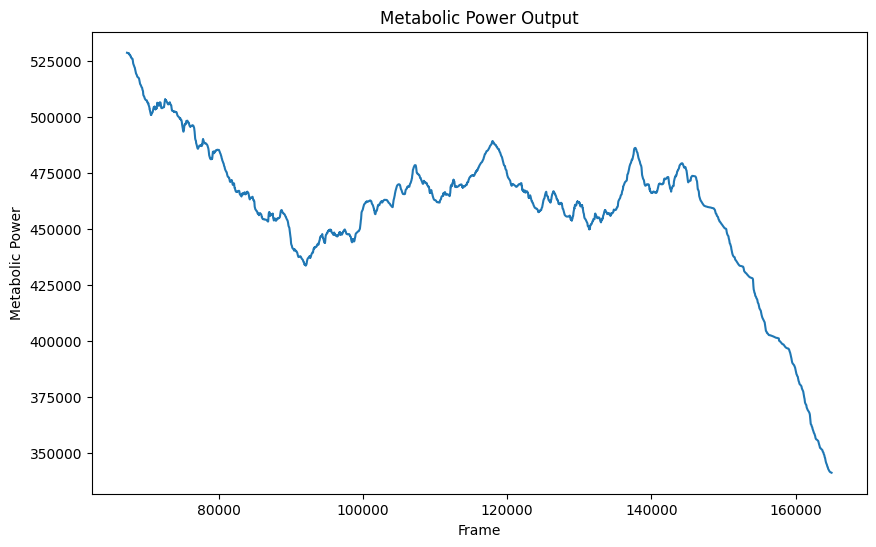

In [12]:
def split_at(s, c, n):
    words = s.split(c)
    return c.join(words[:n]), c.join(words[n:])

#function to calculate metabolic cost
def metabolic_cost(acc): #https://jeb.biologists.org/content/221/15/jeb182303
    if acc > 0:
        cost = 0.102 * ((acc ** 2 + 96.2) ** 0.5) * (4.03 * acc + 3.6 * np.exp(-0.408 * acc))
    elif acc < 0:
        cost = 0.102 * ((acc ** 2 + 96.2) ** 0.5) * (-0.85 * acc + 3.6 * np.exp(1.33 * acc))
    else:
        cost = 0
    return cost

team = tracking_home


fig, ax = plt.subplots(figsize = (10, 6))
player = 'Home_8c34093f-843c-41a4-b02d-1ed289de00a3'
#calculate metabolic cost
mc_temp = list(map(lambda x: metabolic_cost(team[player + '_Acc'][x]), range(0, len(team[player + '_Acc']))))
#multiply it by speed
mp_temp = mc_temp * team[player+'_speed']
print(len(mp_temp))
#calculate rolling average
test_mp = mp_temp.rolling(67257,min_periods=1).apply(lambda x : np.nansum(x)) #Use Changepoint Detection Here
ax.plot(test_mp[67257:])
ax.set_title('Metabolic Power Output')
ax.set_ylabel("Metabolic Power")
ax.set_xlabel("Frame")
plt.show()

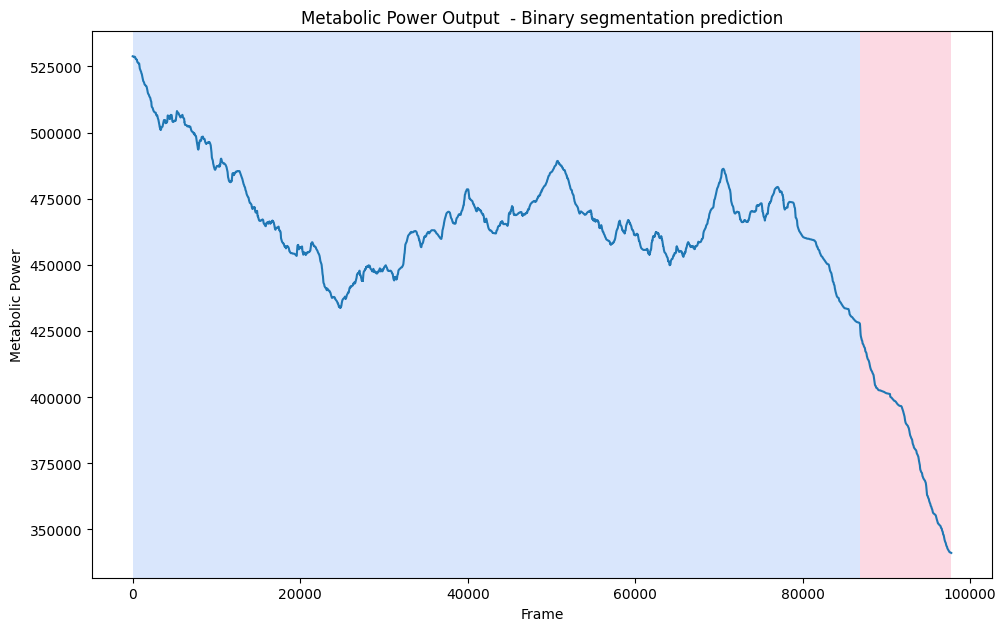

In [13]:
signal = np.array(test_mp[67257:len(test_mp)]).reshape((len(test_mp[67257:len(test_mp)]),1))
algo = rpt.Binseg(model="l2").fit(signal)  ##potentially finding spot where substitution should happen
result = algo.predict(n_bkps=1)  # big_seg
rpt.show.display(signal, result, figsize=(10, 6))
plt.title('Metabolic Power Output  - Binary segmentation prediction')
plt.ylabel("Metabolic Power")
plt.xlabel("Frame")
plt.show()

* heatmap of where player moves
* per player analysis / position / name / distance covered as time passes
* sustained sprints: how many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second
* plot positions at KO (to find out what position each player is playing)
* event analysis of player at the last 10 minutes before swapping


In [ ]:
# plot positions at KO (to find out what position each player is playing)
import friendsoftracking.metrica.IO as mio
tracking_home = mio.read_tracking_data(2, 'Home')
tracking_away = mio.read_tracking_data(2, 'Away')


In [ ]:
import friendsoftracking.metrica.Viz as mviz
mviz.plot_frame( tracking_home.loc[51], tracking_home.loc[51], include_player_velocities=False, annotate=True);

H. Raso - SUB


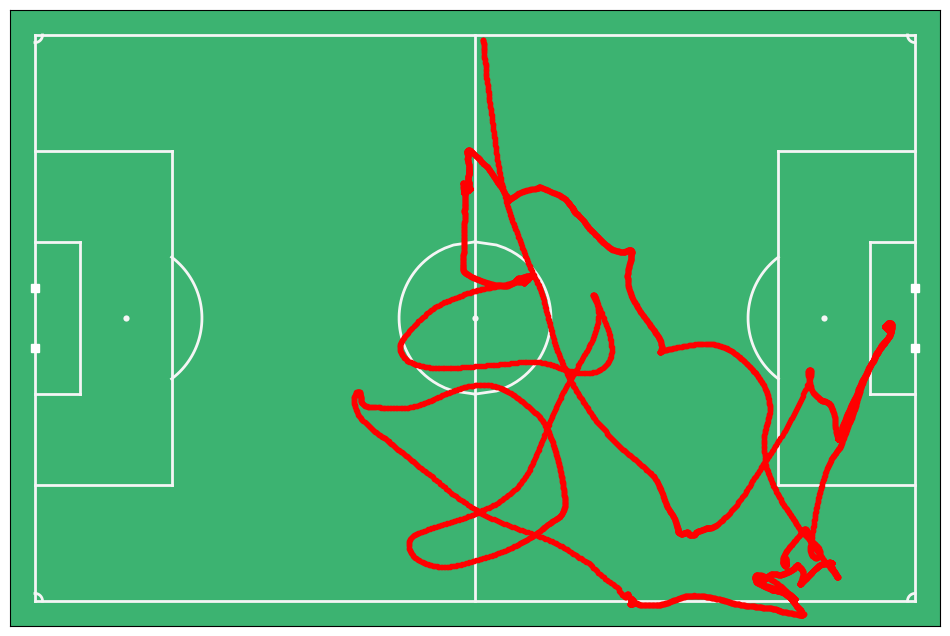

C. Kelly - FW


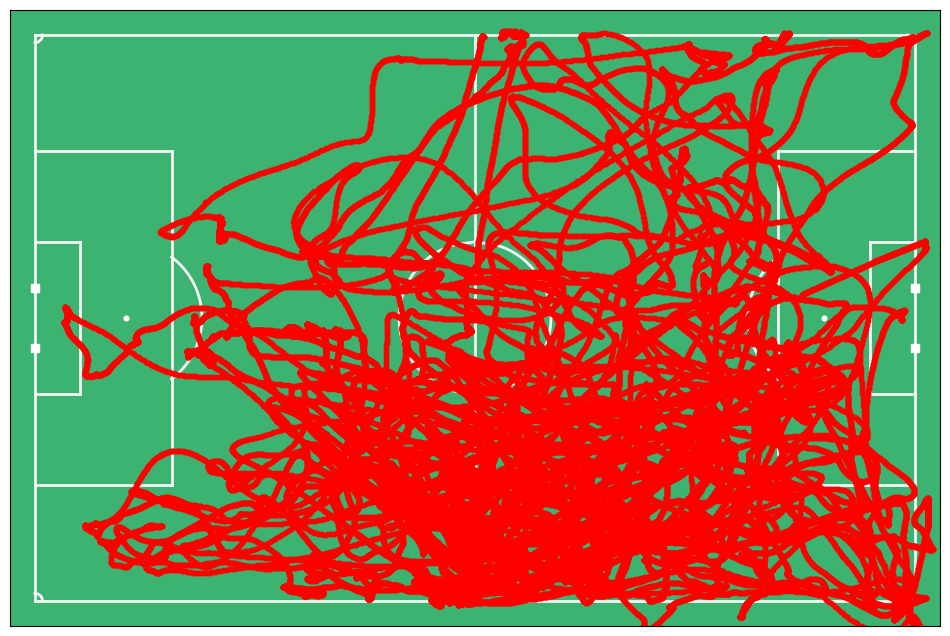

K. Casparij - DF


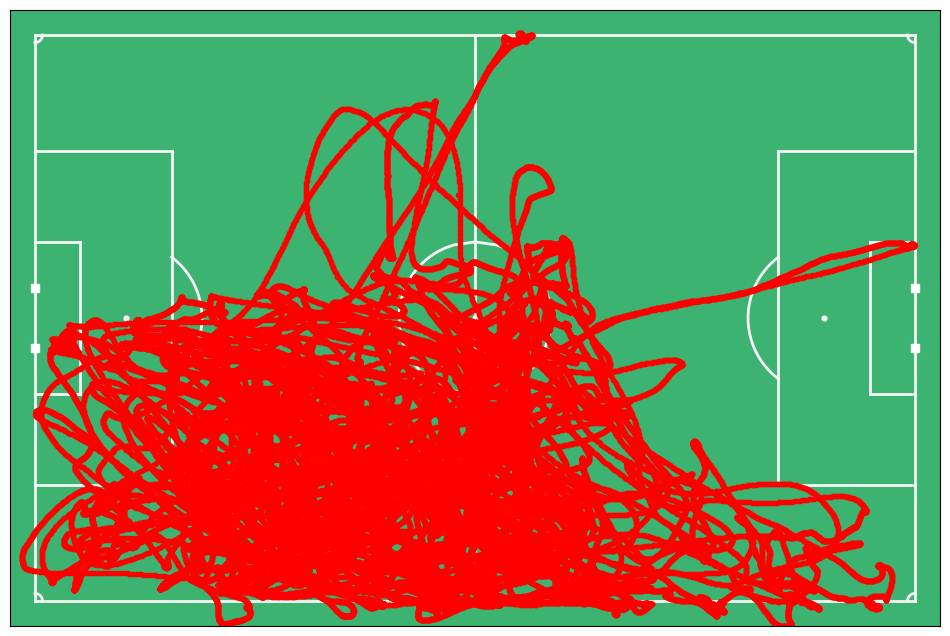

E. Roebuck - GK


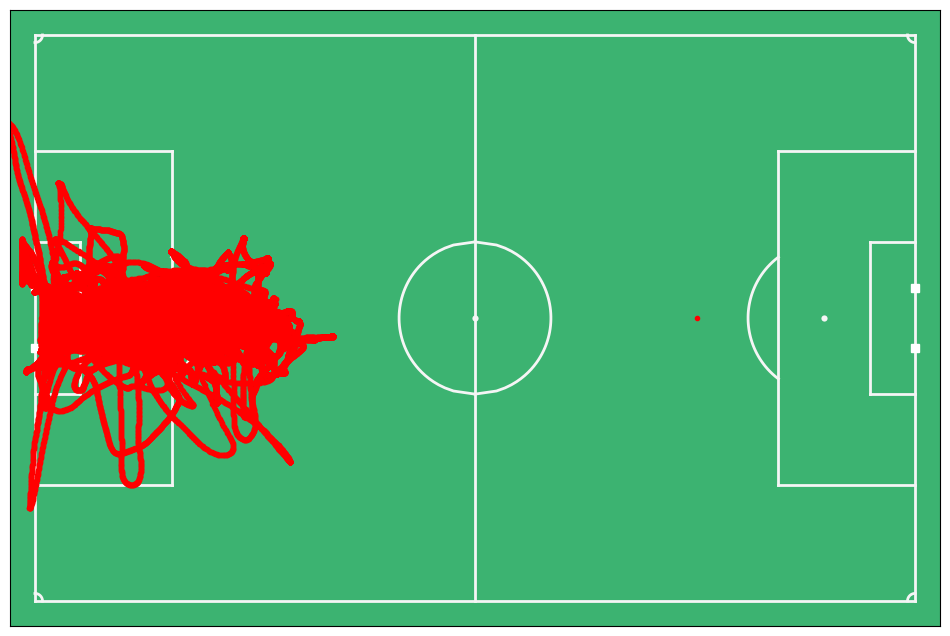

A. Greenwood - DF


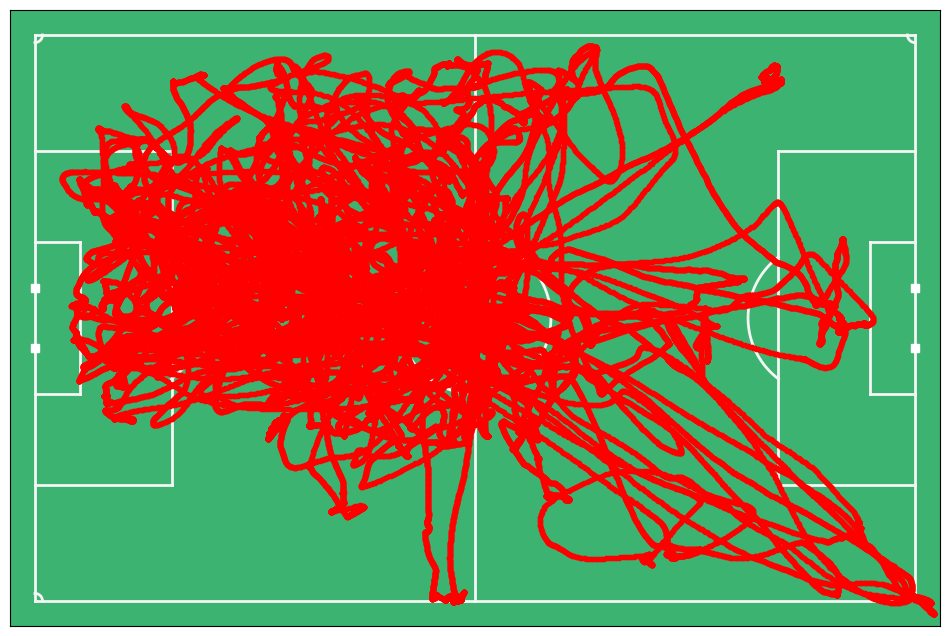

L. Aleixandri - DF


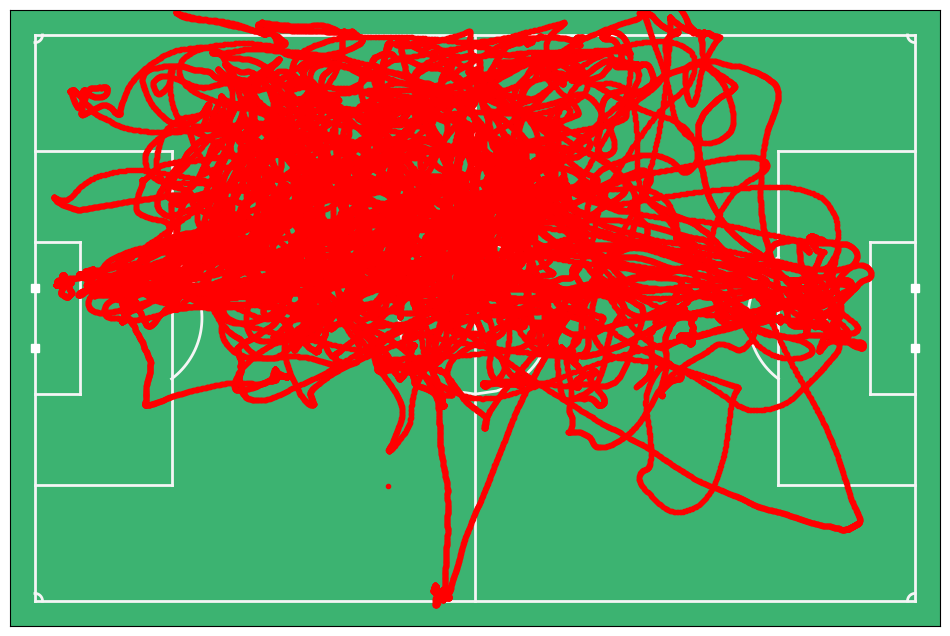

Khadija Shaw - FW


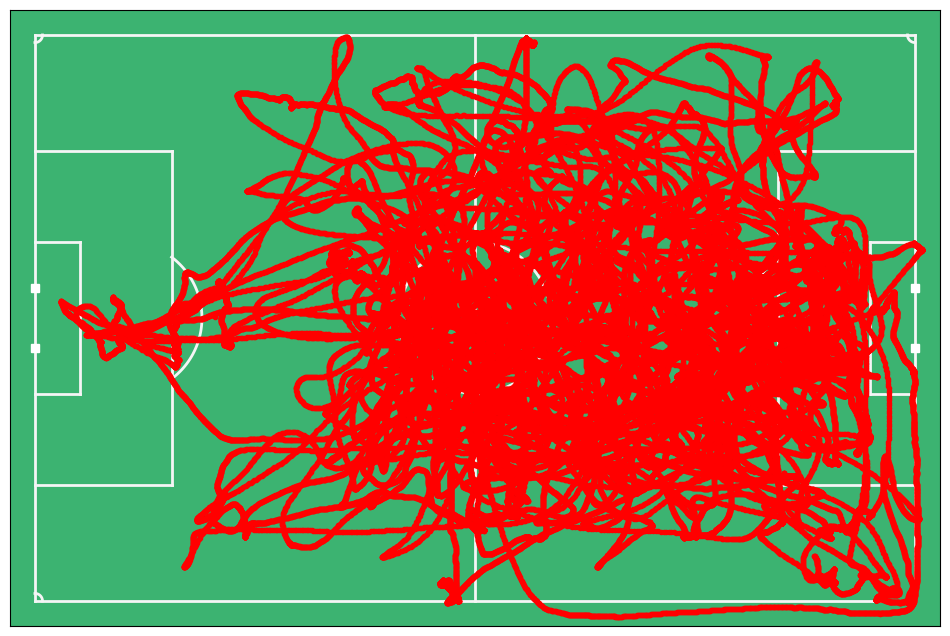

Y. Hasegawa - MF


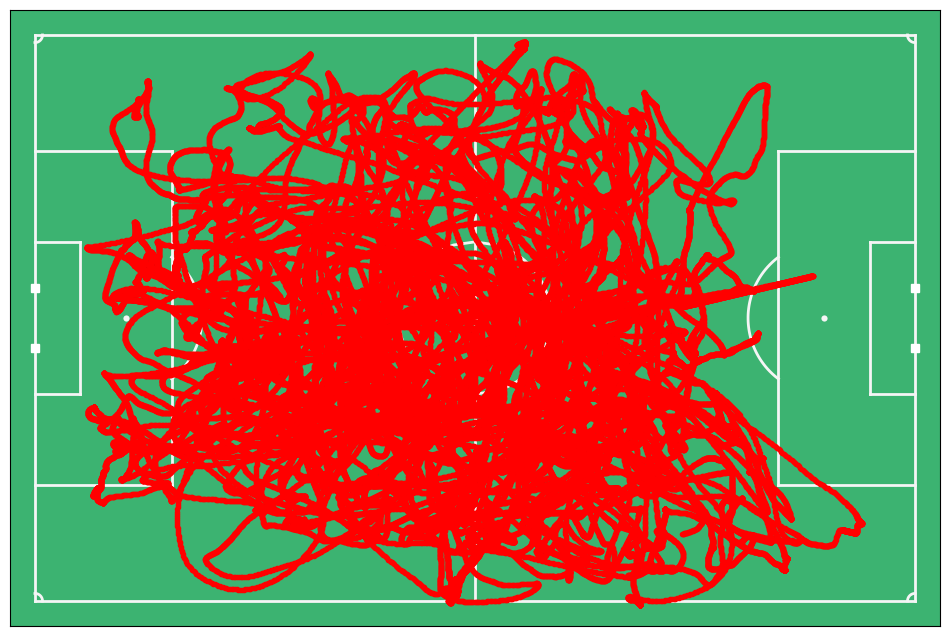

L. Hemp - FW


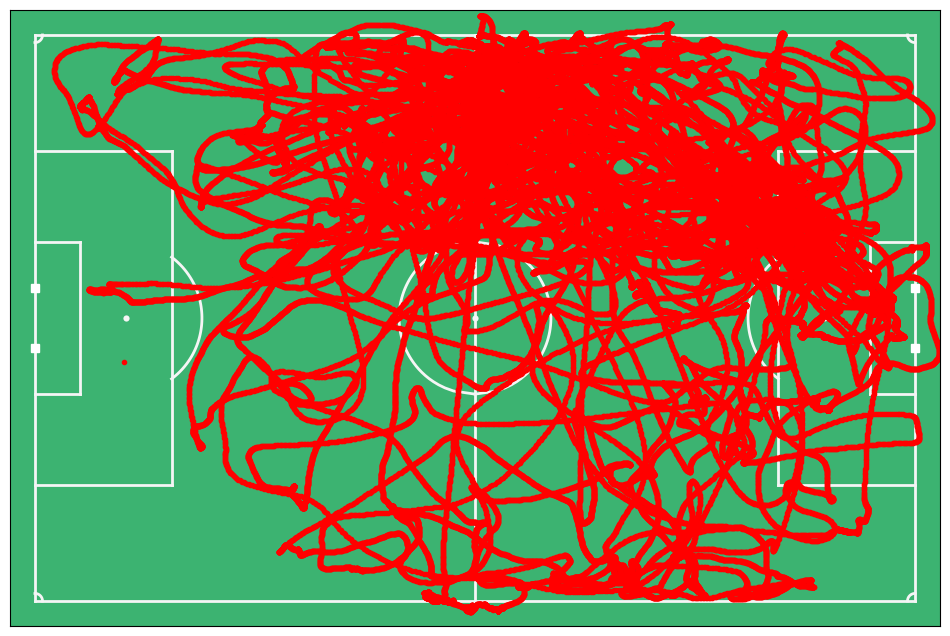

S. Houghton - DF


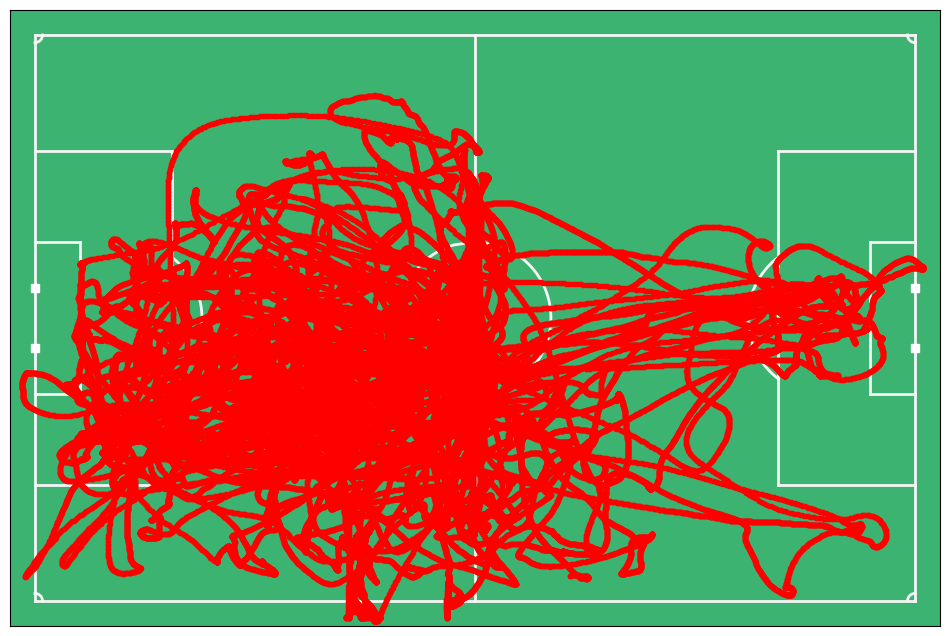

Filippa Angeldahl - MF


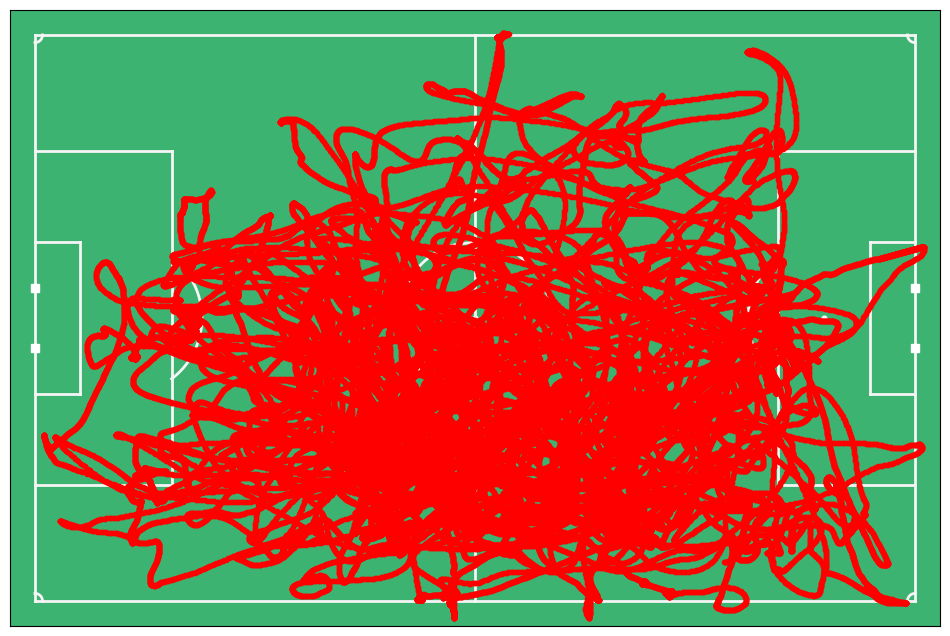

L. Coombs - MF


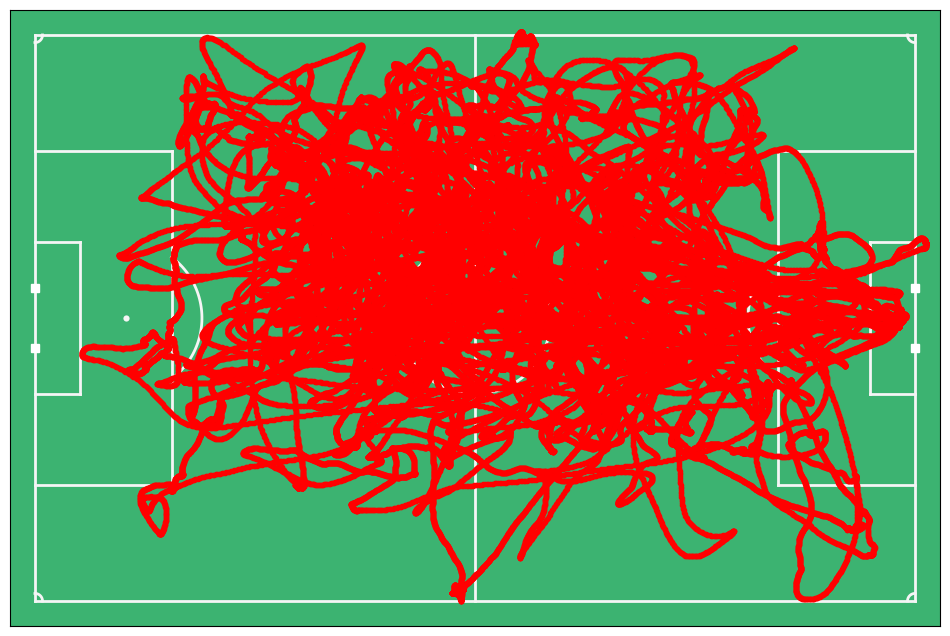

In [14]:
def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2):
    markersize = 20
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax





for i in players_name_and_pos_conc:
    print(players_name_and_pos_conc[i])
    fig,ax = plot_pitch()
    ax.plot( tracking_home[f"Home_{i}_x"], 
    tracking_home[f"Home_{i}_y"], 'r.')
    plt.show()
    
  